# 1. Setup Environment

In [1]:
%matplotlib inline

#setup environment
import psycopg2
import pandas as pd
import pandas.io.sql as psql
import ConfigParser
import os
import IPython
import pyhdb
from IPython.display import display
from IPython.display import HTML
#Maximum height of a result set
pd.set_option('display.max_rows', 50)
#Maximum number of rows to display in a cell.
pd.set_option('display.max_columns', 100)
#Show the full content of columns
pd.set_option('display.max_colwidth', -1)

C:\Anaconda2\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## 1.1 Set up DB Connections

In [20]:
# HAWQ Connection
USER_CRED_FILE = os.path.join(os.path.expanduser('~'), '.dslab_user.cred')

def fetchDBCredentials(dbcred_file=USER_CRED_FILE):
    """
       Read database access credentials from the file in $HOME/.ipynb_dslab.cred
    """
    #Read database credentials from user supplied file
    conf = ConfigParser.ConfigParser()
    conf.read(dbcred_file)
    #host, port, user, database, password
    host = conf.get('database_creds','host')
    port = conf.get('database_creds','port')
    user = conf.get('database_creds','user')
    database = conf.get('database_creds','database')
    password = conf.get('database_creds','password')

    #Initialize connection string
    conn_str =  """dbname='{database}' user='{user}' host='{host}' port='{port}' password='{password}'""".format(                       
                    database=database,
                    host=host,
                    port=port,
                    user=user,
                    password=password
            )
    return conn_str

conn = psycopg2.connect(fetchDBCredentials())
psql.execute("set role pivotal_fmc_poc_dba",conn)
conn.commit()

In [3]:
# HANA Connection
HANA_CRED_FILE = os.path.join(os.path.expanduser('~'), '.hana.cred')

def fetchHanaConnection(dbcred_file=HANA_CRED_FILE):
    """
       Read database access credentials from the file in $HOME/.ipynb_dslab.cred
    """
    #Read database credentials from user supplied file
    conf = ConfigParser.ConfigParser()
    conf.read(dbcred_file)
    #host, port, user, database, password
    host = conf.get('database_creds','host')
    port = conf.get('database_creds','port')
    user = conf.get('database_creds','user')
    database = conf.get('database_creds','database')
    password = conf.get('database_creds','password')
    conn = pyhdb.connect(host=host, port=port, user=user, password=password)
       
    return conn
      
hconn = fetchHanaConnection()


## 1.2 Register SQL MAGICS

In [21]:
from IPython.core.magic import (register_line_magic, register_cell_magic,
                                register_line_cell_magic)

@register_cell_magic
def showsql(line, cell):
    """
        Extract the code in the specific cell (should be valid SQL), and execute
        it using the connection object to the backend database. 
        The resulting Pandas dataframe
        is rendered inline below the cell using IPython.display.
        You'd use this for SELECT
    """
    #Use the global connection object defined above.
    global conn
    _ = psql.read_sql(cell, conn)
    conn.commit()
    display(_)
    return
    
@register_cell_magic
def execsql(line, cell):
    #Use the global connection object defined above.
    global conn
    _ = psql.execute(cell, conn)
    conn.commit()
    return


@register_cell_magic
def hshowsql(line, cell):
    #Use the global connection object defined above.
    global hconn
    _ = psql.read_sql(cell, hconn)
    hconn.commit()
    display(_)
    return
   
# We delete these to avoid name conflicts for automagic to work
del execsql, showsql, hshowsql


## 1.3 Test HANA Connection

In [5]:
%%time
%%hshowsql
select * from sapsr3.ttzz limit 1

,CLIENT,TZONE,ZONERULE,DSTRULE,FLAGACTIVE
0,100,AFGHAN,P0430,NONE,X


Wall time: 341 ms


## 1.4 Test HAWQ connection

In [22]:
%%showsql
select
    random() as x,
    random() as y
from
    generate_series(1, 1);

,x,y
0,0.239476,0.057161


## 1.5 Set timeout and role

In [7]:
%%execsql
set statement_timeout = 0; --100 hours

In [8]:
psql.execute("set role pivotal_fmc_poc_dba",conn)
conn.commit()

# 2 Create Material Feature Table
Create a hybrid score for similarity combining key categorical attributes and Jakard indexes for:
* First level components
* Documents
* Q Specs
* QMsections

## 2.1 Create Jaccard index and part_type cleaning functions

In [67]:
%%execsql
CREATE OR REPLACE FUNCTION smithd2.jaccard_index(
    x text[],
    y text[])
  RETURNS double precision AS
$BODY$
    try:
        n = len(set(x).intersection(y))
        return n / float(len(x) + len(y) - n)
    except:
        return 0.0
$BODY$
  LANGUAGE plpythonu VOLATILE;
ALTER FUNCTION smithd2.jaccard_index(text[], text[])
  OWNER TO pivotal_fmc_poc_dba;

In [68]:
%%execsql

CREATE OR REPLACE FUNCTION smithd2.clean_part_type(part_type text)
  RETURNS text AS
$BODY$
    """
    This function returns the part time if it is a valid part type, 
    else it returns 'other'.
    """
    part_types =  ['N','S','F','O','V','R','X','T','NA',None]
    if part_type in part_types:
        return part_type 
    elif part_type=='STANDARD (S)':
        return 'S' 
    elif part_type=='O35':
        return 'O'
    else:
        return 'other' 

$BODY$
  LANGUAGE plpythonu VOLATILE;
ALTER FUNCTION smithd2.clean_part_type(text)
  OWNER TO pivotal_fmc_poc_dba;


## 2.2 Aggregate BOM components 
(from the latest BOM associated with a plant consisting only of stock and phantom materials on the primary altbom)

In [7]:
%%execsql

DROP TABLE IF EXISTS smithd2.material_component_agg;
CREATE TABLE smithd2.material_component_agg AS
(
    select a.material, array_agg(a.component order by a.component) as components
    from data_science.material_bom a
    inner join    
    ( select case when b.material is not null then b.material else c.material end as material,
        case when b.bom is not null then b.bom else c.bom end as bom
        from    
        (
            SELECT material, max(bom) as bom
            from data_science.material_bom         
            where char_length(trim(both from plnt))=4
            group by material
        ) b        
        full outer join 
        (
            SELECT material, max(bom) as bom
            from data_science.material_bom
            where char_length(trim(both from plnt))=0 
            group by material
        ) c
         on b.material=c.material 
    )d
    on a.material=d.material and a.bom=d.bom
    where char_length(trim(both from a.component))>1 and
        a.material<>a.component and altbom='1' and bomcat='M' and char_length(trim(both from a.material))>1 AND a.ict in ('L', 'M') 
    group by a.material
)
DISTRIBUTED BY (material);

## 2.3 Gather TCE Data

### 2.3.1 Create a table of only latest revision TCE data

In [70]:
%%execsql
DROP TABLE IF EXISTS data_science.zxml_item_parts_latest_rev;
CREATE TABLE data_science.zxml_item_parts_latest_rev AS
(
    select a.obj_name as material, a.field_name, a.value_new
    from data_science.zxml_item_parts a
    inner join
    ( 
        select obj_name, max(obj_key) as obj_key
        from data_science.zxml_item_parts
        where field_name like 'ecn_status%'
        and value_new = 'RELEASED'
        group by obj_name
    ) b
    on a.obj_name=b.obj_name and a.obj_key=b.obj_key
)
DISTRIBUTED BY (material);

### 2.3.2 Create an aggregated table of documents by material from the latest revision data

In [71]:
%%execsql
DROP TABLE IF EXISTS smithd2.material_document_agg;
CREATE TABLE smithd2.material_document_agg AS
(
    select material, array_agg(value_new order by value_new) as documents
    from data_science.zxml_item_parts_latest_rev 
    where field_name like 'document_name%'
    and char_length(trim(both from value_new))>1
    group by material
)
DISTRIBUTED BY (material);

### 2.3.3 Aggregate Qspecs from the latest revision data

In [72]:
%%execsql
DROP TABLE IF EXISTS smithd2.material_qspec_agg;
CREATE TABLE smithd2.material_qspec_agg AS
(
    select material, array_agg(value_new order by value_new) as qspecs
    from data_science.zxml_item_parts_latest_rev 
    where lower(field_name) like 'qspec%'
    and char_length(trim(both from value_new))>1
    group by material
)
DISTRIBUTED BY (material);

### 2.3.4 Aggregate qmsects

In [73]:
%%execsql
DROP TABLE IF EXISTS smithd2.material_qmsect_agg;
CREATE TABLE smithd2.material_qmsect_agg AS
(
    select material, array_agg(value_new order by value_new) as qmsects
    from data_science.zxml_item_parts_latest_rev 
    where lower(field_name) like 'qmsect%'
    and char_length(trim(both from value_new))>1
    group by material
)
DISTRIBUTED BY (material);

### 2.3.5 Aggregate material specs

In [74]:
%%execsql
DROP TABLE IF EXISTS smithd2.material_matlspecs_agg;
CREATE TABLE smithd2.material_matlspecs_agg AS
(
    select material, array_agg(value_new order by value_new) as matlspecs
    from data_science.zxml_item_parts_latest_rev 
    where lower(field_name) like 'material_spec%'
    and char_length(trim(both from value_new))>1
    group by material
)
DISTRIBUTED BY (material);

## 2.3.6 Aggregate weld specs

In [75]:
%%execsql
DROP TABLE IF EXISTS smithd2.material_weldspecs_agg;
CREATE TABLE smithd2.material_weldspecs_agg AS
(
    select material, array_agg(value_new order by value_new) as weldspecs
    from data_science.zxml_item_parts_latest_rev 
    where lower(field_name) like 'weld_spec%'
    and char_length(trim(both from value_new))>1
    group by material
)
DISTRIBUTED BY (material);

### 2.3.7 Aggregate Coating Specs

In [76]:
%%execsql
DROP TABLE IF EXISTS smithd2.material_coatingspecs_agg;
CREATE TABLE smithd2.material_coatingspecs_agg AS
(
    select material, array_agg(value_new order by value_new) as coatingspecs
    from data_science.zxml_item_parts_latest_rev 
    where lower(field_name) like 'coating_spec%'
    and char_length(trim(both from value_new))>1
    group by material
)
DISTRIBUTED BY (material);

### 2.3.8 Create consolidated list of remaining non-aggregated features

In [77]:
%%execsql

DROP TABLE IF EXISTS smithd2.material_tcefeatures;
CREATE TABLE smithd2.material_tcefeatures AS 
SELECT
    material
    ,max(case when lower(field_name)='desc' then value_new end) as "desc"
    ,smithd2.clean_part_type(max(case when lower(field_name)='part_type' then value_new end)) as "part_type"   
    ,max(case when lower(field_name)='model' then value_new end) as "model"       
    ,max(case when lower(field_name)='uom' then value_new end) as "uom"    
    ,max(case when lower(field_name)='prod_family' then value_new end) as "prod_family"
    ,max(case when lower(field_name)='prod_line' then value_new end) as "prod_line"
    ,max(case when lower(field_name)='material_type' then value_new end) as "material_type"   
    ,max(case when lower(field_name)='material_group' then value_new end) as "material_group"   
    ,max(case when lower(field_name)='serialization' then value_new end) as "serialization"
    ,max(case when lower(field_name)='based_on' then value_new end) as "based_on"
    ,max(case when lower(field_name)='commodity_code' then value_new end) as "commodity_code"
   FROM 
    data_science.zxml_item_parts_latest_rev
GROUP BY
    1
DISTRIBUTED BY (material)
;

## 2.4 Generate Features for subsea and surface parts

In [40]:
%%execsql

DROP TABLE IF EXISTS smithd2.material_business;
CREATE TABLE smithd2.material_business AS 
    SELECT a.mat_plant as material, max(CASE WHEN  b.dbbusname = 'SURFACE' then 1 else 0 end )::BOOLEAN  as surface_matl,
    max(CASE WHEN  b.dbbusname LIKE 'SUBSEA%' then 1 else 0 end )::BOOLEAN  as subsea_matl
    from sap_bi.bi0_pmat_plant_int a
    inner join sap_bi.bi0_pplant_int b
    on a.plant=b.plant
    group by mat_plant
Distributed by (material);


In [45]:
%%showsql


    SELECT sum(case when surface_matl then 1 else 0 end) as surf, 
    sum(case when subsea_matl then 1 else 0 end) as subsea, count(*) as count     
    FROM smithd2.material_features



,surf,subsea,count
0,259338,288789,405946


NOTE: grouping parts into surface and subsea will only reduce load by 9%
vs running full join

FULL JOIN = 406k^2 165 Billion pairs
SUBSEA + SURFACE JOINS = 150 Billion pairs

## 2.5 Create feature table for scoring
Combine generated features plus split the first 4 terms of the description to be used as unique features

In [41]:
%%execsql
DROP TABLE IF EXISTS smithd2.material_features;
CREATE TABLE smithd2.material_features AS
(
    select a.material, b.components, c.coatingspecs, d.documents, e.matlspecs, f.qmsects, g.qspecs, h.weldspecs,
        replace(replace(i.net_weight,'"',''),',','')::float as weight, 
        a.desc, 
        split_part(a.desc, ',', 1) as desc1, split_part(a.desc, ',', 2) as desc2, split_part(a.desc, ',', 3) as desc3,
        substring(a.desc, ',[^,]*,[^,]*,(.*)' ) as desc4,    
        a.model, 
        a.prod_family, 
        a.serialization, a.based_on, a.commodity_code,
        coalesce(i.baseunit, a.uom) as uom,        
        coalesce(i.product_line, a.prod_line) as prod_line, 
        coalesce(i.material_type, a.material_type) as material_type, 
        coalesce(i.material_group, a.material_group) as material_group,
        j.surface_matl,
        j.subsea_matl
    from smithd2.material_tcefeatures a
        left outer join smithd2.material_component_agg b on a.material=b.material
        left outer join smithd2.material_coatingspecs_agg c on a.material=c.material
        left outer join smithd2.material_document_agg d on a.material=d.material
        left outer join smithd2.material_matlspecs_agg e on a.material=e.material
        left outer join smithd2.material_qmsect_agg f on a.material=f.material
        left outer join smithd2.material_qspec_agg g on a.material=g.material
        left outer join smithd2.material_weldspecs_agg h on a.material=h.material
        left outer join data_science.sap_material_master i on a.material=i.material
        inner join smithd2.material_business j on a.material=j.material
)
DISTRIBUTED BY (material);

In [42]:
%%showsql

select * from smithd2.material_features

limit 1

,material,components,coatingspecs,documents,matlspecs,qmsects,qspecs,weldspecs,weight,desc,desc1,desc2,desc3,desc4,model,prod_family,serialization,based_on,commodity_code,uom,prod_line,material_type,material_group,surface_matl,subsea_matl
0,P7000057876,None,None,"[4067, SPC70013427]",[M11800],"[7QM0000_1.1.1, 7QM0000_3.1, 7QM0000_9.1.1]",None,None,117.0,"FRAME WELDMENT, XT SIDE GRATING",FRAME WELDMENT,XT SIDE GRATING,,None,DS700155450,TREE FRAME,NO,P7000055913,,EA,,HALB,99,True,True


Check result

In [26]:
%%showsql

select count(*)
from smithd2.material_features

,count
0,405946


# 3 Generate Score for sample
Take a 1% random sample of smithd2.material_features (ex: create table material_1pct as select * from smithd2.material_features where random() < 0.1 distributed by (material) ; ) and run query to estimate how long it takes to run. Let's call this "x" seconds. Then you can say it will take roughly 10000x the time on a 1% sample. 

NOTE: The performance of the query will scale linearly with the total number of #nodes*segments/node. 

## 3.1 Sample 1% of material features table

In [27]:
%%execsql
DROP TABLE IF EXISTS smithd2.material_features_sample;
CREATE TABLE smithd2.material_features_sample AS
(
    select * from smithd2.material_features where random() < 0.001  
)
DISTRIBUTED BY (material);

In [28]:
%%time
%%showsql

select count(*)
from smithd2.material_features_sample

,count
0,404


Wall time: 531 ms


## 3.2 Generate distance metric on Sample

In [30]:
%%time
%%execsql
DROP TABLE IF EXISTS smithd2.material_features_sample_distance;
set statement_timeout = 0; 
CREATE TABLE smithd2.material_features_sample_distance as
(    
    SELECT a.material as material, b.material as similar_material, 
    --this intial case whenspeeds it up by limiting heavy math to at least one key field match
     CASE WHEN a.material=b.material then 0 
     WHEN
       ( a.prod_line = b.prod_line or a.model=b.model or  a.commodity_code=b.commodity_code
            or a.prod_family=b.prod_family or a.material=b.based_on or a.based_on=a.material or a.desc1=b.desc1)                 
     THEN            
       ( case when a.weight>0.1 and b.weight>0.1 then 0.3 * (abs(a.weight-b.weight)/GREATEST(a.weight,b.weight)) else 0.1 end +    
        CASE WHEN a.model=b.model then 0 else 0.3 end +    
        case when a.material=b.based_on or a.based_on=a.material then 0 else 0.3 end +        
        (1.0 - smithd2.jaccard_index(a.documents, b.documents)) * .3 +   
        (1.0 - smithd2.jaccard_index(a.components, b.components)) * .4 + 
        case when char_length(a.desc1)>0 and char_length(b.desc1)>0 
            then 0.3 * pdltools.demerau_levenshtein_distance( a.desc1, b.desc1 )
                 / GREATEST(char_length(a.desc1),char_length(b.desc1))  
            else 0 end +    
        case when char_length(a.desc2)>0 and char_length(b.desc2)>0 
            then 0.2 * pdltools.demerau_levenshtein_distance( a.desc2, b.desc2 )
                 / GREATEST(char_length(a.desc2),char_length(b.desc2))  
            else 0 end + 
        case when char_length(a.desc3)>0 and char_length(b.desc3)>0 
            then 0.2 * pdltools.demerau_levenshtein_distance( a.desc3, b.desc3 )
                 / GREATEST(char_length(a.desc3),char_length(b.desc3))  
           else 0 end +
        case when char_length(a.desc4)>0 and char_length(b.desc4)>0 
           then 0.2 * pdltools.demerau_levenshtein_distance( a.desc4, b.desc4 )
                 / GREATEST(char_length(a.desc4),char_length(b.desc4))  
            else 0 end + 
        case when a.uom=b.uom then 0 else 0.3 end +
        case when a.prod_family=b.prod_family then 0 else 0.1 end +
        case when a.prod_line=b.prod_line then 0 else 0.1 end +
        (1.0 - smithd2.jaccard_index(a.matlspecs, b.matlspecs)) * .2 +
        (1.0 - smithd2.jaccard_index(a.weldspecs, b.weldspecs)) * .2 +
        case when a.serialization=b.serialization 
            or a.serialization is null and b.serialization is null then 0 
            when a.serialization is not null and b.serialization is not null         
            then 0.05 else 0.2 end +     
        (1.0 - smithd2.jaccard_index(a.qspecs, b.qspecs)) * .2 +
        (1.0 - smithd2.jaccard_index(a.qmsects, b.qmsects)) * .2 +       
        (1.0 - smithd2.jaccard_index(a.coatingspecs, b.coatingspecs)) * .2 +           
        case when a.material_type=b.material_type then 0 else 0.2 end +    
        case when a.commodity_code=b.commodity_code then 0 else 0.1 end) / 4.2
    ELSE 1.0 END
        as score
    FROM smithd2.material_features_sample a
    CROSS JOIN smithd2.material_features_sample b      
    WHERE (a.surface_matl=b.surface_matl or a.subsea_matl=b.subsea_matl)
    order by a.material, b.material
)
DISTRIBUTED BY (material);


Wall time: 13 s


In [11]:
%%showsql

SELECT *
from smithd2.material_features_sample_distance 
where material='100000116'


,material,similar_material,score
0,100000116,02-433-903,1.000000
1,100000116,100000116,0.000000
2,100000116,100039811,0.652381
3,100000116,100043497,0.739393
4,100000116,100050307-BLUE,0.744268
5,100000116,1100011162806,1.000000
6,100000116,110531040511,1.000000
7,100000116,114070100110,1.000000
8,100000116,114860720744,1.000000
9,100000116,1156402583801,1.000000


## 3.3 Plot the distribution of Gower's dissimilarity score (will be later used in determining the threshold for hierarchical clustering)

In [12]:
%%showsql
select
    ntile,
    min(score) as min_gower_dissimilarity_score,
    max(score) as max_gower_dissimilarity_score,
    avg(score) as mean_gower_dissimilarity_score
from
(
    select
        ntile(200) over( order by score) as ntile,
        score
    from
    (
        select
            score
        from
            smithd2.material_features_sample_distance
        where
           material > similar_material
        order by random()
        -- Take 100K random pairs of points
        limit 100000
    )q1
)q2
group by ntile
order by ntile

,ntile,min_gower_dissimilarity_score,max_gower_dissimilarity_score,mean_gower_dissimilarity_score
0,1,0.368481,0.628205,0.598423
1,2,0.628247,0.646115,0.636863
2,3,0.646141,0.657920,0.653289
3,4,0.657920,0.663919,0.661079
4,5,0.663919,0.669753,0.666893
5,6,0.669786,0.673469,0.671762
6,7,0.673469,0.677265,0.675419
7,8,0.677265,0.682514,0.679660
8,9,0.682517,0.688120,0.685382
9,10,0.688131,0.692869,0.690587


In [13]:
sql = """
    select
        score
    from
        smithd2.material_features_sample_distance
    where
        material > similar_material and score<20
    order by random()
    -- Take 100K random pairs of points
    limit 100000;
"""
df = psql.read_sql(sql, conn)
conn.commit()

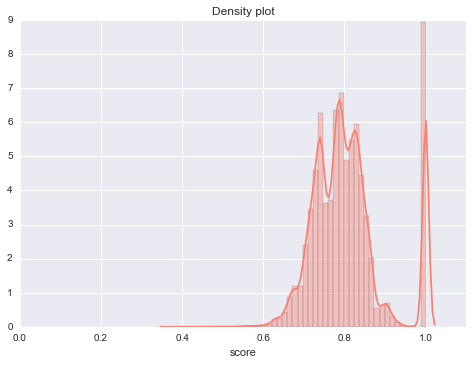

In [14]:
import seaborn as sns
sns.distplot(df['score'], color='salmon')
sns.plt.title('Density plot')
sns.plt.xlim(0)
sns.plt.show()

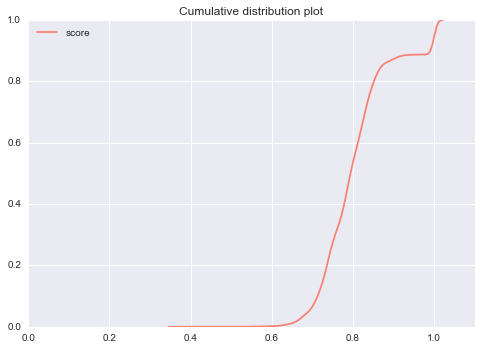

In [15]:
import seaborn as sns
kde = sns.kdeplot(df['score'], cumulative=True, color='salmon')
sns.plt.title('Cumulative distribution plot')
sns.plt.xlim(0)
sns.plt.show()

In [16]:
threshold_hclust = 0.65

From the above plots, we'll use a cut-off/threshold of 2.80 for the gower_dissimilarity_score while running the hierarchical clustering algorithm. Less than 1% of the pairs of materials have a dissimilarity score < threshold_hclust and are likely to correspond to closely related materials.

## 3.3 Test hierachical Clustering

With a suitable distance/dissimilarity metric in place, we can use a [hierarchical clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering)  algorithm like [complete linkage clustering](https://en.wikipedia.org/wiki/Complete-linkage_clustering) to identify parts that fall into same cluster.First, we will compute all pairs of distances between our inputs, using which we will run hierarchical clustering on the above table using scipy's functions to mimic [complete linkage module in PDLTools](http://pivotalsoftware.github.io/PDLTools/group__grp__complete__linkage.html)


### 3.3.1 Define UDFs and UDAs for running hierarchical clustering through SciPy

In [12]:
%%execsql
--1) Define return type (material, cluster_number)
drop type if exists smithd2.hclust_results_type cascade;
create type smithd2.hclust_results_type
as
(
    material text,
    cluster_number int
);

--2) SFUNC
drop function if exists smithd2.stack_rows(
    text,
    text[],
    text,
    text,
    float8
) cascade;
create or replace function smithd2.stack_rows(
    key text,
    header text[],
    material text,
    similar_material text,
    score float8
)
returns text
as
$$
    if 'header' not in GD:
        GD['header'] = header
    if not key:
        gd_key = 'stack_large_array'
        GD[gd_key] = [[material, similar_material, score]]
        return gd_key
    else:
        GD[key].append([material, similar_material, score])
        return key
$$language plpythonu;

--3) Define UDA
drop aggregate if exists smithd2.stack_rows( 
    text[],
    text, 
    text, 
    float8
) cascade;
create ordered aggregate smithd2.stack_rows(
        text[], -- header
        text, -- material
        text, -- similar_material
        float8 -- score
    )
(
    SFUNC = smithd2.stack_rows,
    STYPE = text -- the key in GD used to hold the data across calls
);

--4) Define UDF to retrieve the data from the key in GD and run hierarchical clustering
drop function if exists smithd2.run_hclust(text, float8) cascade;
create or replace function smithd2.run_hclust(key text, threshold float8)
returns setof smithd2.hclust_results_type
as
$$    
    import numpy as np
    import scipy.cluster.hierarchy as hcl
    from scipy.cluster.hierarchy import fcluster
    from scipy.spatial.distance import squareform    
    import pandas as pd    
    if key in GD:     
        df = pd.DataFrame(GD[key], columns=GD['header'])                
        data_piv = df.pivot(*GD['header']).fillna(0)        
        
        piv_arr = data_piv.as_matrix()
        dist_mat = piv_arr + np.transpose(piv_arr)
        
        #Complete linkage hierarchical clustering (w/ pre-computed Gower's distances)
        hclust_results = hcl.linkage(squareform(dist_mat), method='complete')
                
        clusters = fcluster(hclust_results, threshold, criterion='distance')
        cluster_allocation = pd.DataFrame(       
            zip(sorted(list(set(df[GD['header'][0]]))), clusters), 
            columns=['material','cluster_number']
        )
        result = cluster_allocation.values.tolist()
         
        del GD[key]
        return result
    else:
        plpy.info('returning None')
        return None        
    
$$ language plpythonu;

### 3.3.2 Run hierarchical clustering and store the results

In [13]:
threshold_hclust = 0.63

sql = """
drop table if exists smithd2.hclust_results;
create table smithd2.hclust_results
as
(
    select (result).material, (result).cluster_number
    from
    (
        select smithd2.run_hclust(key, .63) as result 
        from 
        (
            select
                smithd2.stack_rows( ARRAY['material', 'similar_material', 'score'],
                    material, 
                    similar_material, 
                    score) as key
            from smithd2.material_features_sample_distance 
            where  material >= similar_material              
        ) q1
    ) q2
) distributed by (material);
""".format(
    threshold_hclust = threshold_hclust
)
psql.execute(sql, conn)
conn.commit()

In [14]:
%%showsql
select
    *
from
    smithd2.hclust_results
limit 10;

,material,cluster_number
0,48-081-017,341
1,70-H20305-144QP,359
2,90-123-675,214
3,P1000004321,122
4,P1000152596,286
5,P210578,58
6,P4000029819,19
7,P7000002596,302
8,P7000034395,364
9,P7000040118,121


### 3.3.3 Explain clusters

In [15]:
%%showsql
select
    *
from
(
    select
        cluster_number,
        count(distinct material) as num_materials
    from
        smithd2.hclust_results
    group by cluster_number
) tbl
-- only list those clusters which have at least 2 elements (as we need to find excess inventory)
where num_materials > 1  
order by 2 desc;

,cluster_number,num_materials
0,372,9
1,351,7
2,359,6
3,318,5
4,367,5
5,38,5
6,171,4
7,11,4
8,287,4
9,13,4


### For all elements in a given cluster, return pairwise dissimilarity scores.

### For materials appearing to be similar in the table above, show the raw features


In [17]:
sql = """
drop table if exists smithd2.hclust_results_w_model_sme_review cascade;
create table smithd2.hclust_results_w_model_sme_review
as
(
    select
        t1.cluster_number,
        t3.material,
        t3.similar_material,
        t3.score
    from
        smithd2.hclust_results t1,
        smithd2.hclust_results t2,
        smithd2.material_features_sample_distance t3
    where
        t1.material > t2.material and
        t1.material = t3.material and
        t2.material = t3.similar_material and
        score < {threshold_hclust}
    order by
        cluster_number,
        score
) distributed randomly;
""".format(
    threshold_hclust=threshold_hclust
)
psql.execute(sql, conn)
conn.commit()

In [18]:
%%showsql
select * 
from smithd2.hclust_results_w_model_sme_review 
limit 5

,cluster_number,material,similar_material,score
0,33,P7000002480,P6000075717,0.629059
1,55,P203121-2051,P2000051913,0.619493
2,206,SP-12-6893,P1000004321,0.616270
3,219,P7000062727,P6000091114,0.615263
4,257,82-741-017,18-305-802,0.595928


In [20]:
%%execsql
drop table if exists smithd2.hclust_results_w_model_sme_review_raw_features cascade;
create table smithd2.hclust_results_w_model_sme_review_raw_features
as
(
    select
        tbl1.cluster_number,
        tbl2.*
    from
    (
        select
            cluster_number,
            material
        from
        (
            select
                cluster_number,
                material
            from
                smithd2.hclust_results_w_model_sme_review
            union all
            select
                cluster_number,
                similar_material as material
            from
                smithd2.hclust_results_w_model_sme_review 
        )t1
        group by 
            cluster_number,
            material
    ) tbl1,
    smithd2.material_features_sample tbl2
    where
        tbl1.material = tbl2.material
) distributed randomly;

In [22]:
%%showsql
select
    *
from
    smithd2.hclust_results_w_model_sme_review_raw_features
order by
    cluster_number,
    material;

,cluster_number,material,components,coatingspecs,documents,matlspecs,qmsects,qspecs,weldspecs,weight,desc,desc1,desc2,desc3,desc4,model,prod_family,serialization,based_on,commodity_code,uom,prod_line,material_type,material_group
0,1,554758001,None,None,[PS01060],None,None,None,None,NaN,WEIGHT - K12 ROTOR BALANCING WEIGHT 1.2 LBS,WEIGHT - K12 ROTOR BALANCING WEIGHT 1.2 LBS,,,None,554758001,,,554758001/002.01;1-WEIGHT,,EA,,,P-PRT-000
1,1,P1000158165,"[7106098, 7106100, 7107011, 7107389, 7107921, P1000034446, P1000039637, P1000049127, P1000058908, P1000062379, P1000063945, P1000069047, P1000120168, P1000141408, P1000158166, P1000158798, P1000159280, P135372, P137571-1039, P137574-1039, P166334, P170378]",None,"[ADF10030485, ASY100001910, ASY10051974, DA100052163, ENGINEERING, MSM10112476, NOTE, NOTE, NOTE, PRODUCTION, PSM10062309, RPT10077814, RPT10079952, SERVICE, THI10035062, TST100010135]",None,"[1QM1060_4.11, 1QM1060_4.3.10, 1QM1060_4.3.7, 1QM1060_8.10.2, 1QM1060_9.5.3]",None,None,NaN,"STEEL FLYING LEAD, ASSY, MQC-13 MKII BOTH ENDS, 10-LINES, 350 FT LONG, 15K, GEN II, Q47 TO HCDM, F/ BP GSH PROJECTS",STEEL FLYING LEAD,ASSY,MQC-13 MKII BOTH ENDS,"10-LINES, 350 FT LONG, 15K, GEN II, Q47 TO HCDM, F/ BP GSH PROJECTS",,STEEL FLYING LEAD,Q03401,P1000158075,,EA,SUBSEA,,None
2,1,P8000005621,None,None,None,None,None,None,None,1.00,IC REG LDO 3.3V .3A 8-MSOP,IC REG LDO 3.3V .3A 8-MSOP,,,None,,,,,,EA,,HALB,R-PDM-000
3,1,P8000012862,"[529926002, 529926004, 529973111, P8000012410]",None,"[PS01157, PS01158, PS01724, TD02731, TD02738]",None,None,None,None,NaN,VALVE - 4-150 MOD200-60A VA/V SET AT 225 PSI,VALVE - 4-150 MOD200-60A VA/V SET AT 225 PSI,,,None,,,,P8000012862/000.00;6-VALVE,,EA,,,A-VLV-000
4,9,701-637-055,None,None,"[4022, EC701-637]",[M36101],"[1QM0000_4.9.2, 7QM0000_5.3]",None,None,0.00,"TYPE HEAVY HEX NUT, 1 IN - 8UNC-2B",TYPE HEAVY HEX NUT,1 IN - 8UNC-2B,,None,NO-DWG,,Q03402,P179257,,PCE,,HALB,O-F03-000
5,9,78-020-616,None,[C81007],None,[M36101],"[1QM0000_4.9.2, 1QM0000_5.2]",None,None,3.00,"PAD STUD, 1.375-8UN-2A X 6.25 IN LG, A 453 GR 660, EXP, PTFE",PAD STUD,1.375-8UN-2A X 6.25 IN LG,A 453 GR 660,"EXP, PTFE",NO-DWG,THREADED FASTENER,Q03402,,,EA,,HALB,99
6,9,78-120-562,"[78-020-562, 78-030-248, 78-033-097]",None,None,None,"[1QM0000_4.9.2, 1QM0000_5.2]",None,None,0.00,"PAD STUD W/ NUT, 1.250-8UN-2A X 5.75 IN LG, A 320 GR L7, NON-EXP, PTFE",PAD STUD W/ NUT,1.250-8UN-2A X 5.75 IN LG,A 320 GR L7,"NON-EXP, PTFE",NO-DWG,THREADED FASTENER,Q03402,,,EA,,HALB,99
7,9,DP-78-0814,None,"[C81000, C81004]",None,[M21901],"[1QM0000_4.9.3, 1QM0000_5.2]",None,None,27.00,"PAD STUD, ROTABOLT, 2.250-8UN-2A X 23.50 IN LG, A 320 GR L7, NON-EXP, PTFE, W/ TENSION CONTROL INDICATOR SET TO 70000 PSI",PAD STUD,ROTABOLT,2.250-8UN-2A X 23.50 IN LG,"A 320 GR L7, NON-EXP, PTFE, W/ TENSION CONTROL INDICATOR SET TO 70000 PSI",NO-DWG,THREADED FASTENER,Q03401,,,EA,,ROH,99
8,9,P1000091493,None,"[C81000, C81004]",None,[M21907],"[1QM0000_4.9.2, 1QM0000_5.2]",None,None,0.17,"HVY HEX HEAD SCREW, .500-13UNC-2A/3A X 2.00 LG, A 320 GR L7S, NON EXP, PTFE, SUBSEA STANDARD",HVY HEX HEAD SCREW,.500-13UNC-2A/3A X 2.00 LG,A 320 GR L7S,"NON EXP, PTFE, SUBSEA STANDARD",NO-DWG,THREADED FASTENER,Q03402,P1000090912,,EA,,HALB,O-F03-000
9,9,P1000091771,None,"[C81000, C81004]",None,[M21906],"[1QM0000_4.9.2, 1QM0000_5.2]",None,None,0.05,"CAP SCREW, HEX SOCKET DRIVE, .375-16UNC-2A/3A X .88 LG, A 320 GR L7M, EXP LOW STR, PTFE, SUBSEA STANDARD",CAP SCREW,HEX SOCKET DRIVE,.375-16UNC-2A/3A X .88 LG,"A 320 GR L7M, EXP LOW STR, PTFE, SUBSEA STANDARD",NO-DWG,THREADED FASTENER,Q03402,P1000085813,,EA,,HALB,99


# 4.0 Generate full sample
Don't run this unless you have 4 days to wait unless big improvements have been made!

In [11]:
%%execsql

DROP TABLE IF EXISTS smithd2.material_features_distance_subsea;
set statement_timeout = 0; 
CREATE TABLE smithd2.material_features_distance_subsea as
(    
    SELECT a.material as material, b.material as similar_material,     
     CASE WHEN a.material=b.material then 0
    --this case whenspeeds it up by limiting heavy math to at least one key field match
    WHEN
       ( a.prod_line = b.prod_line or a.model=b.model or  a.commodity_code=b.commodity_code
            or a.prod_family=b.prod_family or a.material=b.based_on or a.based_on=a.material or a.desc1=b.desc1) 
     THEN            
       ( case when a.weight>0.1 and b.weight>0.1 then 0.3 * (abs(a.weight-b.weight)/GREATEST(a.weight,b.weight)) else 0.1 end +    
        CASE WHEN a.model=b.model then 0 else 0.3 end +    
        case when a.material=b.based_on or a.based_on=a.material then 0 else 0.3 end +        
        (1.0 - smithd2.jaccard_index(a.documents, b.documents)) * .3 +   
        (1.0 - smithd2.jaccard_index(a.components, b.components)) * .4 + 
        case when char_length(a.desc1)>0 and char_length(b.desc1)>0 
            then 0.3 * pdltools.demerau_levenshtein_distance( a.desc1, b.desc1 )
                 / GREATEST(char_length(a.desc1),char_length(b.desc1))  
            else 0 end +    
        case when char_length(a.desc2)>0 and char_length(b.desc2)>0 
            then 0.2 * pdltools.demerau_levenshtein_distance( a.desc2, b.desc2 )
                 / GREATEST(char_length(a.desc2),char_length(b.desc2))  
            else 0 end + 
        case when char_length(a.desc3)>0 and char_length(b.desc3)>0 
            then 0.2 * pdltools.demerau_levenshtein_distance( a.desc3, b.desc3 )
                 / GREATEST(char_length(a.desc3),char_length(b.desc3))  
           else 0 end +
        case when char_length(a.desc4)>0 and char_length(b.desc4)>0 
           then 0.2 * pdltools.demerau_levenshtein_distance( a.desc4, b.desc4 )
                 / GREATEST(char_length(a.desc4),char_length(b.desc4))  
            else 0 end + 
        case when a.uom=b.uom then 0 else 0.3 end +
        case when a.prod_family=b.prod_family then 0 else 0.1 end +
        case when a.prod_line=b.prod_line then 0 else 0.1 end +
        (1.0 - smithd2.jaccard_index(a.matlspecs, b.matlspecs)) * .2 +
        (1.0 - smithd2.jaccard_index(a.weldspecs, b.weldspecs)) * .2 +
        case when a.serialization=b.serialization 
            or a.serialization is null and b.serialization is null then 0 
            when a.serialization is not null and b.serialization is not null         
            then 0.05 else 0.2 end +     
        (1.0 - smithd2.jaccard_index(a.qspecs, b.qspecs)) * .2 +
        (1.0 - smithd2.jaccard_index(a.qmsects, b.qmsects)) * .2 +       
        (1.0 - smithd2.jaccard_index(a.coatingspecs, b.coatingspecs)) * .2 +           
        case when a.material_type=b.material_type then 0 else 0.2 end +    
        case when a.commodity_code=b.commodity_code then 0 else 0.1 end) / 4.2
      ELSE 1.0 END
        as score
    FROM smithd2.material_features a
    CROSS JOIN smithd2.material_features b
    where 
        a.material<>b.material  
        and a.subsea_matl=1
        and b.subsea_matl=1
    order by a.material, b.material
)
DISTRIBUTED BY (material);

DatabaseError: Execution failed on sql: 
DROP TABLE IF EXISTS smithd2.material_features_distance;
set statement_timeout = 0; 
CREATE TABLE smithd2.material_features_distance as
(    
    SELECT a.material as material, b.material as similar_material,     
     CASE WHEN a.material=b.material then 0
    --this case whenspeeds it up by limiting heavy math to at least one key field match
    WHEN
       ( a.prod_line = b.prod_line or a.model=b.model or  a.commodity_code=b.commodity_code
            or a.prod_family=b.prod_family or a.material=b.based_on or a.based_on=a.material or a.desc1=b.desc1) 
     THEN            
       ( case when a.weight>0.1 and b.weight>0.1 then 0.3 * (abs(a.weight-b.weight)/GREATEST(a.weight,b.weight)) else 0.1 end +    
        CASE WHEN a.model=b.model then 0 else 0.3 end +    
        case when a.material=b.based_on or a.based_on=a.material then 0 else 0.3 end +        
        (1.0 - smithd2.jaccard_index(a.documents, b.documents)) * .3 +   
        (1.0 - smithd2.jaccard_index(a.components, b.components)) * .4 + 
        case when char_length(a.desc1)>0 and char_length(b.desc1)>0 
            then 0.3 * pdltools.demerau_levenshtein_distance( a.desc1, b.desc1 )
                 / GREATEST(char_length(a.desc1),char_length(b.desc1))  
            else 0 end +    
        case when char_length(a.desc2)>0 and char_length(b.desc2)>0 
            then 0.2 * pdltools.demerau_levenshtein_distance( a.desc2, b.desc2 )
                 / GREATEST(char_length(a.desc2),char_length(b.desc2))  
            else 0 end + 
        case when char_length(a.desc3)>0 and char_length(b.desc3)>0 
            then 0.2 * pdltools.demerau_levenshtein_distance( a.desc3, b.desc3 )
                 / GREATEST(char_length(a.desc3),char_length(b.desc3))  
           else 0 end +
        case when char_length(a.desc4)>0 and char_length(b.desc4)>0 
           then 0.2 * pdltools.demerau_levenshtein_distance( a.desc4, b.desc4 )
                 / GREATEST(char_length(a.desc4),char_length(b.desc4))  
            else 0 end + 
        case when a.uom=b.uom then 0 else 0.3 end +
        case when a.prod_family=b.prod_family then 0 else 0.1 end +
        case when a.prod_line=b.prod_line then 0 else 0.1 end +
        (1.0 - smithd2.jaccard_index(a.matlspecs, b.matlspecs)) * .2 +
        (1.0 - smithd2.jaccard_index(a.weldspecs, b.weldspecs)) * .2 +
        case when a.serialization=b.serialization 
            or a.serialization is null and b.serialization is null then 0 
            when a.serialization is not null and b.serialization is not null         
            then 0.05 else 0.2 end +     
        (1.0 - smithd2.jaccard_index(a.qspecs, b.qspecs)) * .2 +
        (1.0 - smithd2.jaccard_index(a.qmsects, b.qmsects)) * .2 +       
        (1.0 - smithd2.jaccard_index(a.coatingspecs, b.coatingspecs)) * .2 +           
        case when a.material_type=b.material_type then 0 else 0.2 end +    
        case when a.commodity_code=b.commodity_code then 0 else 0.1 end) / 4.2
      ELSE 1.0 END
        as score
    FROM smithd2.material_features a
    CROSS JOIN smithd2.material_features b
    where 
        a.material<>b.material  
)
DISTRIBUTED BY (material);
server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.

unable to rollback

# 5.0 Do heirarchal clustering on results

Repeat relevant steps from 3 above.

In [6]:
%%showsql

SELECT * From smithd2.material_features_distance;

,material,similar_material,score
0,P4000024729,241103102884085,1.000000
1,P4000024729,P6000123368,0.773134
2,P4000024729,P1000005609,0.906902
3,P4000024729,P1000038348,0.821086
4,P4000024729,P7000008738,0.783972
5,P4000024729,930-181-249,0.743088
6,P4000024729,P401089-0002,0.683908
7,P4000024729,P1000139766,0.815341
8,P4000024729,P412772,0.840789
9,P4000024729,18-305-800,0.796124
